In [29]:
import os
import csv
import json

import pandas as pd
import numpy as np

import pycocotools.coco as coco
from pycocotools.coco import COCO

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import webcolors

import ipywidgets as widgets
from IPython.display import display, clear_output

In [30]:
class_dict = pd.read_csv("/opt/ml/mask_visualizer/class_dict.csv")

categories_dict = {
    0: "Background" ,
    1: "General trash",
    2: "Paper",
    3: "Paper pack",
    4: "Metal",
    5: "Glass",
    6: "Plastic",
    7: "Styrofoam",
    8: "Plastic bag",
    9: "Battery",
    10: "Clothing",
}

CATEGORIES = list(categories_dict.values())
PALETTE = [[0, 0, 0], [192, 0, 128], [0, 128, 192], [0, 128, 64], [128, 0, 0],
           [64, 0, 128], [64, 0, 192], [192, 128, 64], [192, 192, 128],
           [64, 64, 128], [128, 0, 192]]
 
category_and_rgb = [[category, palette] for(category, palette) in zip(CATEGORIES, PALETTE)]
legend_elements = [Patch(facecolor=webcolors.rgb_to_hex(rgb), 
                        edgecolor=webcolors.rgb_to_hex(rgb), 
                        label=category) for category, rgb in category_and_rgb]

In [31]:
def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_dict.values):
        colormap[inex] = [r, g, b]
    
    return colormap

def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
                is the color indexed by the corresponding element in the input label
                to the trash color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
              map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

In [32]:
# ----- select category id ----- #
category_id = 10
category_name = categories_dict[category_id]

data_path = '/opt/ml/input/data/'
data_path_ = f'/opt/ml/mask_visualizer/data/{category_id}_{category_name}/'

data_list = pd.read_csv(data_path_ + f"/_{category_name}.csv")
image_list = data_list['image_name']

In [33]:
def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

def view_image(b):
    
    global idx
    
    clear_output(wait=True)
    
    if idx == len(image_list) :
        print("[last image]")
        idx -= 1
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
    
    image_path = f"{data_path}{image_list[idx]}"
    
    # Open the image file and display it
    with open(image_path, 'rb') as f:
        image = plt.imread(f)
    
    ax1.set_title(f"{image_list[idx]}", fontsize = 15)
    ax1.imshow(image)
    ax1.axis('off')
    
    mask_ = list(image_list[idx].split('.'))[0]
    mask = f"{data_path_}{mask_}.json"

    with open(mask, 'r') as f :
        annotations = json.load(f)

    image_infos = annotations['images'][0]
    img_id = image_infos['id']

    coco_obj = coco.COCO(mask)
    anno_id = coco_obj.getAnnIds(imgIds=img_id)
    annotations = coco_obj.loadAnns(ids=anno_id)
    cat_ids = coco_obj.getCatIds()
    cats = coco_obj.loadCats(cat_ids)

    masks = np.zeros((image_infos["height"], image_infos["width"]))
    annotations = sorted(annotations, key=lambda idx : idx['area'], reverse=True)
    for i in range(len(annotations)):
        className = get_classname(annotations[i]['category_id'], cats)
        pixel_value = CATEGORIES.index(className)
        masks[coco_obj.annToMask(annotations[i]) == 1] = pixel_value
    masks = masks.astype(np.int8)
    
    ax2.set_title((f"{mask_} mask"), fontsize = 15)
    ax2.imshow(label_to_color_image(masks))
    ax2.axis('off')
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    
    display(select_idx, botton)
    
def on_value_change(change):
    # Update the global variable
    global idx
    idx = change['new']
    # Print the global variable

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


IntSlider(value=62, continuous_update=False, description='image_list', max=114)

Button(description='vizualize', style=ButtonStyle())

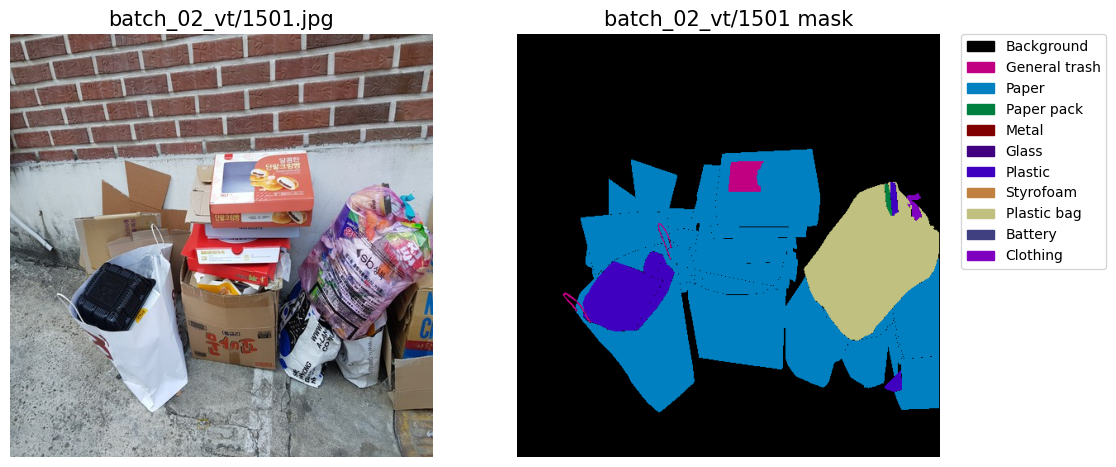

In [34]:
idx = 0
select_idx = widgets.IntSlider(
    value=idx,
    min=0,
    max=len(image_list),
    step=1,
    description='image_list',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

botton = widgets.Button(description='vizualize')
botton.on_click(view_image)

select_idx.observe(on_value_change, names='value')

display(select_idx, botton)